## Feito o tutorial do video:
https://www.youtube.com/watch?v=tHL5STNJKag&t=1200s

In [2]:
import torch

In [3]:
torch.cuda.is_available()

True

In [4]:
import opendatasets as od

In [5]:
od.download('https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification/data')

Skipping, found downloaded files in "./cards-image-datasetclassification" (use force=True to force download)


In [6]:
!pip3 install ipywidgets --user

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [7]:
!pip install timm

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.12.5 (main, Aug 23 2024, 00:00:00) [GCC 14.2.1 20240801 (Red Hat 14.2.1-1)]
PyTorch version 2.4.0+cu121
Torchvision version 0.19.0+cu121
Numpy version 1.26.4
Pandas version 2.2.1


In [9]:
import torch
torch.cuda.empty_cache()

In [10]:

class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [11]:
dataset = PlayingCardDataset(
    data_dir='cards-image-datasetclassification/train'
)

41


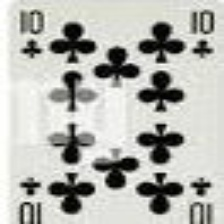

In [12]:
image, label = dataset[6000]
print(label)
image

In [13]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

data_dir='cards-image-datasetclassification/train'
dataset = PlayingCardDataset(data_dir, transform)

In [14]:

# iterate over dataset
for image, label in dataset:
    break

In [15]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [16]:
for images, labels in dataloader:
    break

In [22]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        #self.base_model = timm.create_model('vit_mediumd_patch16_reg4_gap_256.sbb2_e200_in12k_ft_in1k',num_classes=32)

            
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        ) # saida como linear 
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [23]:
torch.cuda.FloatTensor

torch.cuda.FloatTensor

In [24]:

model = SimpleCardClassifer(num_classes=53)
print(str(model)[:500])

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal


In [25]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

In [26]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_folder = 'cards-image-datasetclassification/train/'
valid_folder = 'cards-image-datasetclassification/valid/'
test_folder = 'cards-image-datasetclassification/test/'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [73]:
torch.cuda.is_available()

True

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [75]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 7.65 GiB of which 36.94 MiB is free. Process 1427 has 94.00 MiB memory in use. Including non-PyTorch memory, this process has 7.18 GiB memory in use. Of the allocated memory 7.01 GiB is allocated by PyTorch, and 35.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()